**Imports**

In [16]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim import models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules, Adam, SGD, RMSprop
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import gensim
import plotly.graph_objects as go
import tensorflow as tf
import gensim.downloader
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip freeze > /content/drive/MyDrive/DLA_dataset/requirements.txt

/bin/bash: /content/drive/MyDrive/DLA_dataset/requirements.txt: No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load dataset**

In [ ]:
# Load train data
train = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_train.csv', encoding="latin1")

# Load test data
test = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_test.csv', encoding="latin1")

# Merge train and test data
dataset = pd.concat([train, test])

Show a tweet for every label

In [ ]:
res = dataset.loc[dataset['Sentiment'] == 'Positive'].iloc[0]
print(res['OriginalTweet'])

advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order


In [ ]:
res = dataset.loc[dataset['Sentiment'] == 'Extremely Positive'].iloc[0]
print(res['OriginalTweet'])





We thank you for your patience during this time.


In [ ]:
res = dataset.loc[dataset['Sentiment'] == 'Negative'].iloc[0]
print(res['OriginalTweet'])

For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona


In [ ]:
res = dataset.loc[dataset['Sentiment'] == 'Extremely Negative'].iloc[0]
print(res['OriginalTweet'])





#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n


In [ ]:
res = dataset.loc[dataset['Sentiment'] == 'Neutral'].iloc[0]
print(res['OriginalTweet'])

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8


**Pre-Processing**

In [ ]:
# Clean text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]', ' ', text)
    return substitute

# Apply functions on OriginalTweet of Train set
print(dataset['OriginalTweet'].iloc[15])
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : remove_url(x))
print(dataset['OriginalTweet'].iloc[15])
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : remove_emoji(x))
print(dataset['OriginalTweet'].iloc[15])
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : decontraction(x))
print(dataset['OriginalTweet'].iloc[15])
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
print(dataset['OriginalTweet'].iloc[15])
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
print(dataset['OriginalTweet'].iloc[15])
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : char(x))
print(dataset['OriginalTweet'].iloc[15])
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : x.lower())
print(dataset['OriginalTweet'].iloc[15])





#coronavirus #covid19 https://t.co/ZHbh898lf6




#coronavirus #covid19 
Lines at the grocery store have been unpredictable, but is eating out a safe alternative? 

Find out more about whether you should be avoiding restaurants right now:  

#coronavirus #covid19 
Lines at the grocery store have been unpredictable, but is eating out a safe alternative? 

Find out more about whether you should be avoiding restaurants right now:  

#coronavirus #covid19 
Lines at the grocery store have been unpredictable but is eating out a safe alternative Find out more about whether you should be avoiding restaurants right now coronavirus covid 19
Lines at the grocery store have been unpredictable but is eating out a safe alternative Find out more about whether you should be avoiding restaurants right now coronavirus covid 19
Lines at the grocery store have been unpredictable but is eating out a safe alternative Find out more about whether you should be avoiding restaurants right now coronavirus co

**Plot number of words in the tweets**

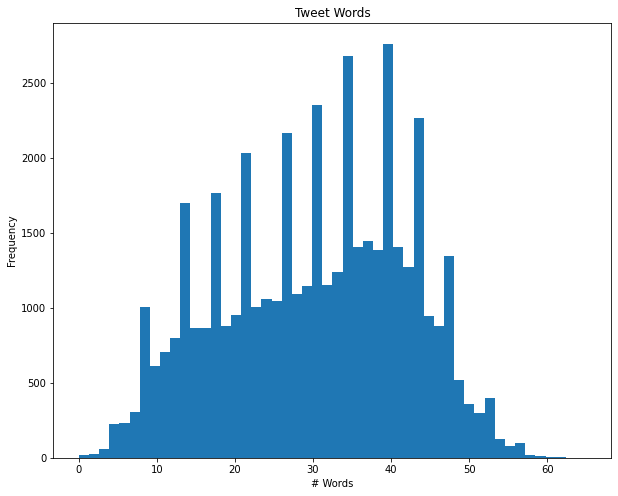

In [ ]:
dataset['TotalWords'] = dataset['OriginalTweet'].str.lower().str.split().apply(len)

dataset['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Words").set_xlabel("# Words")
plt.show()

**Word cloud**

In [ ]:
 # Split sentiment groups 
Positive = dataset[(dataset['Sentiment'] == "Extremely Positive") | (dataset['Sentiment'] == "Positive")].OriginalTweet
Neutral  = dataset[(dataset['Sentiment'] == "Extremely Negative") | (dataset['Sentiment'] == "Negative")].OriginalTweet
Negative = dataset[dataset['Sentiment'] == "Neutral"].OriginalTweet

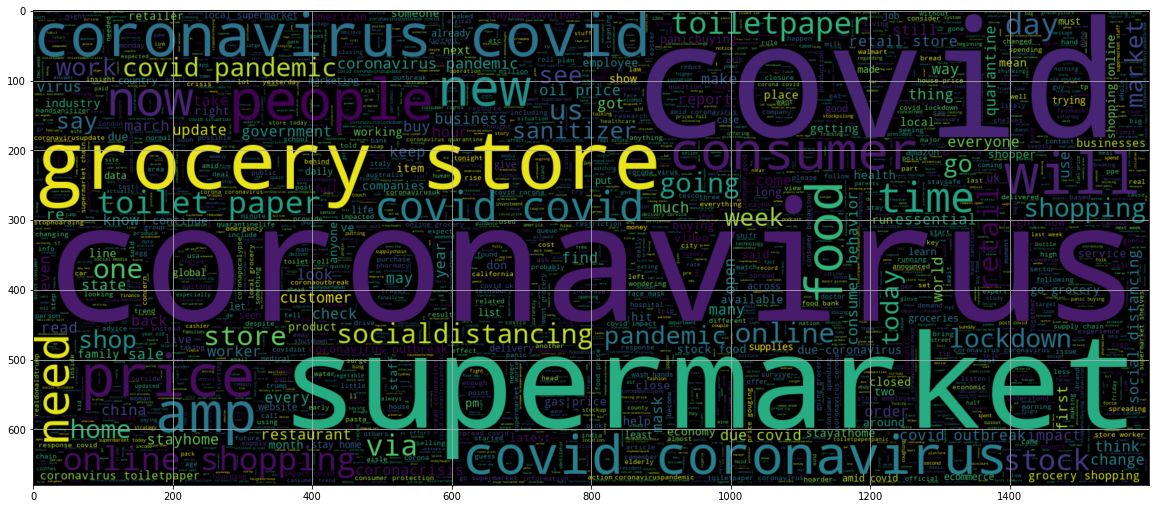

In [ ]:
# WordCloud of Negative Tweets 
plt.figure(figsize = (20,20))
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Negative))
plt.imshow(wordcould, interpolation = 'bilinear')
plt.grid(None)

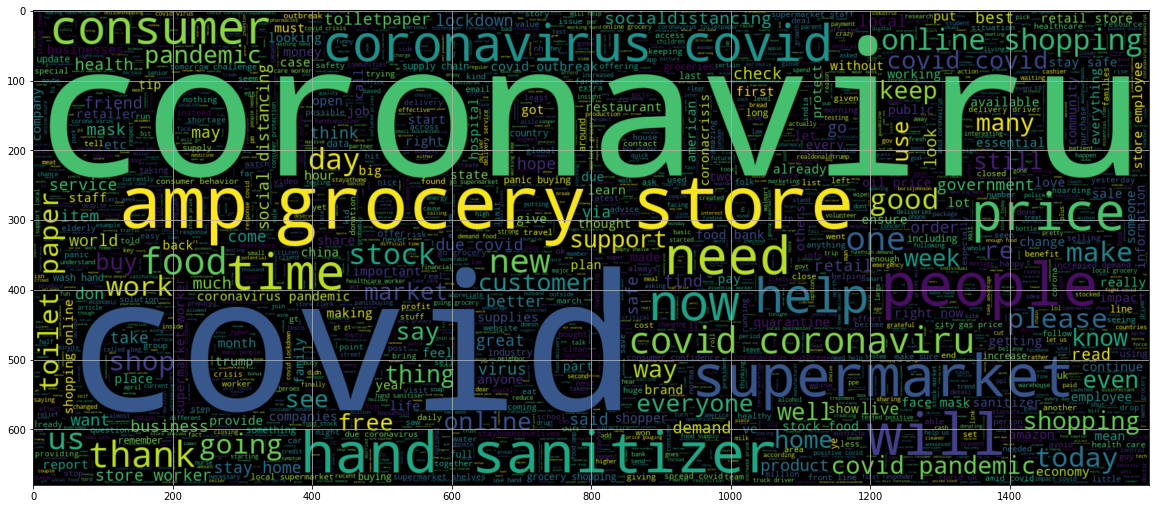

In [ ]:
# WordCloud of Positive Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Positive))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

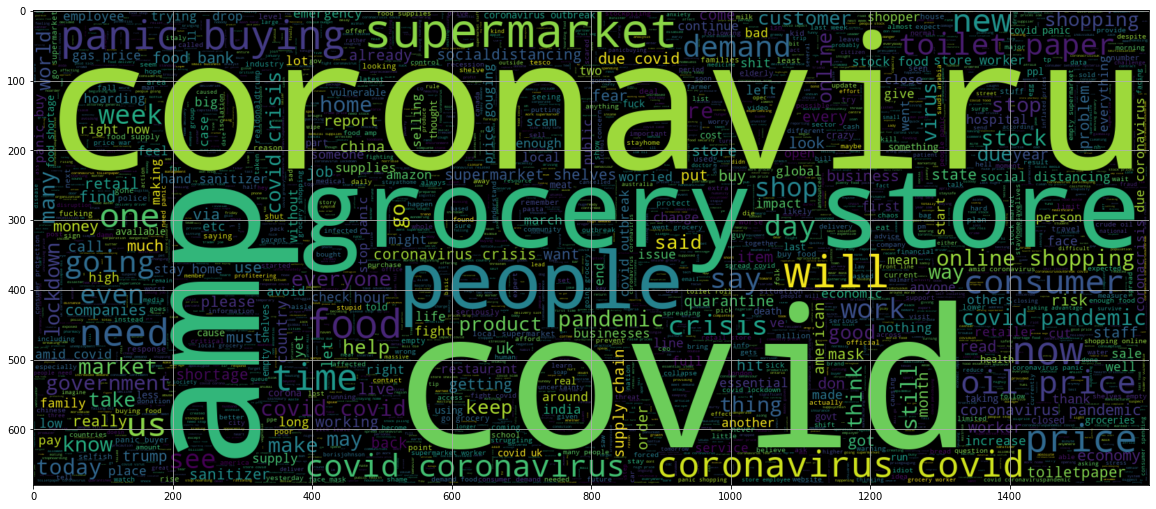

In [ ]:
# WordCloud of Neutral Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Neutral))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

**Split dataset**

In [ ]:
X = dataset['OriginalTweet']
Y = dataset['Sentiment']

# Split data into train , test
X_train , X_test , Y_train , Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

# Split data into train , validation
X_train , X_val , Y_train , Y_val = train_test_split(X_train, Y_train, test_size=0.11, random_state=0)

num_label_train_index, num_label_train_values = np.unique(Y_train, return_counts=True)
num_label_test_index, num_label_test_values = np.unique(Y_test, return_counts=True)
num_label_val_index, num_label_val_values = np.unique(Y_val, return_counts=True)

**Save splitted dataset**

In [ ]:
np.save('/content/drive/MyDrive/DLA_dataset/X_train', X_train, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DLA_dataset/X_test', X_test, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DLA_dataset/X_val', X_val, allow_pickle=True, fix_imports=True)

np.save('/content/drive/MyDrive/DLA_dataset/y_train', Y_train, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DLA_dataset/y_test', Y_test, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DLA_dataset/y_val', Y_val, allow_pickle=True, fix_imports=True)

**Load splitted dataset**

In [3]:
X_train = pd.Series(np.load('/content/drive/MyDrive/DLA_dataset/X_train.npy', allow_pickle=True))
X_test = pd.Series(np.load('/content/drive/MyDrive/DLA_dataset/X_test.npy', allow_pickle=True))
X_val = pd.Series(np.load('/content/drive/MyDrive/DLA_dataset/X_val.npy', allow_pickle=True))

Y_train = pd.Series(np.load('/content/drive/MyDrive/DLA_dataset/y_train.npy', allow_pickle=True))
Y_test = pd.Series(np.load('/content/drive/MyDrive/DLA_dataset/y_test.npy', allow_pickle=True))
Y_val = pd.Series(np.load('/content/drive/MyDrive/DLA_dataset/y_val.npy', allow_pickle=True))

num_label_train_index, num_label_train_values = np.unique(Y_train, return_counts=True)
num_label_test_index, num_label_test_values = np.unique(Y_test, return_counts=True)
num_label_val_index, num_label_val_values = np.unique(Y_val, return_counts=True)

**Plot class distribution**

In [ ]:
def plot_class_dist(labels, tweets, title, max_item, c):
  
  all_colors = list(plt.cm.colors.cnames.keys())

  plt.figure(figsize=(12,10), dpi= 80)

  plt.bar(labels, tweets, color=c, width=.5)
  for i, val in enumerate(tweets):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
  plt.title(title, fontsize=22)
  plt.gca().set_xticklabels(labels, rotation=60, horizontalalignment= 'right', fontsize=16)
  plt.ylabel('# Tweets', fontsize=16)
  plt.ylim(0, max_item)
  plt.show()

**Plot distribution of the classes in train set and test set with five labels**

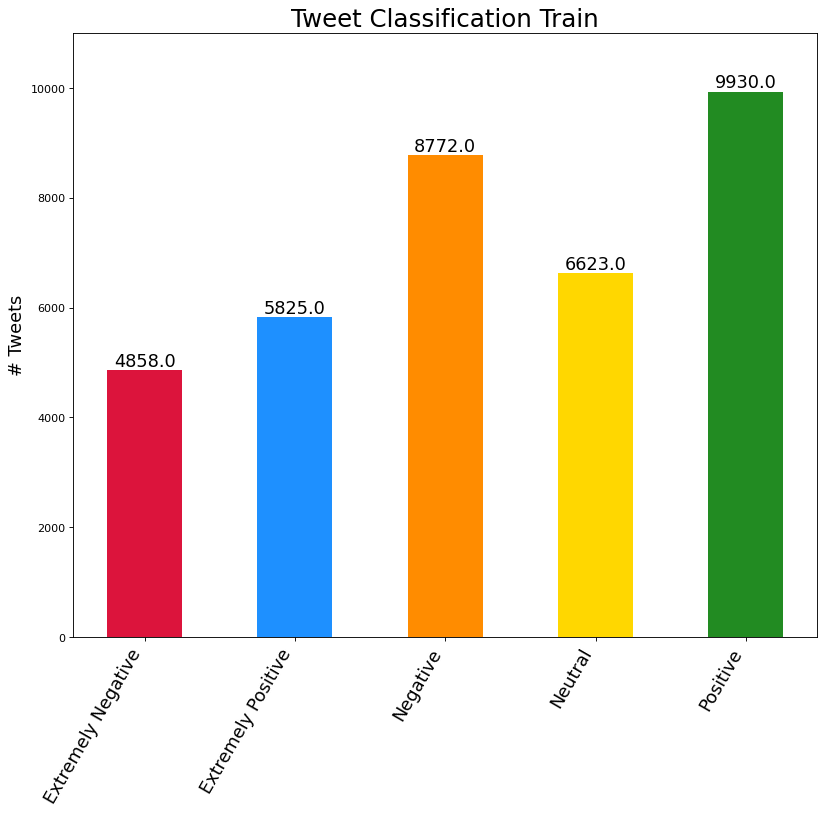

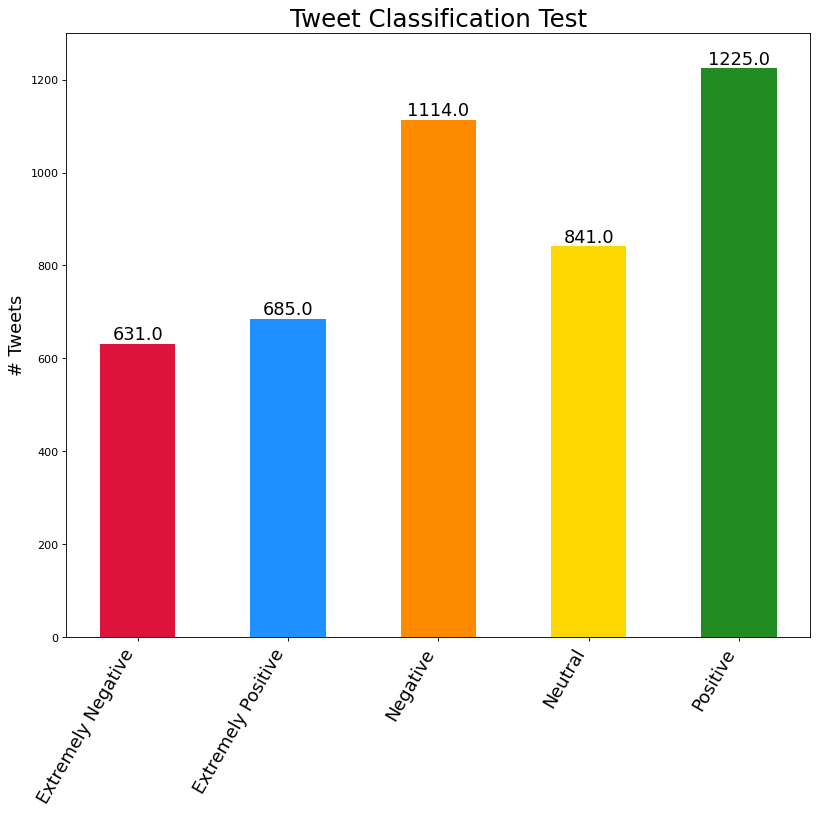

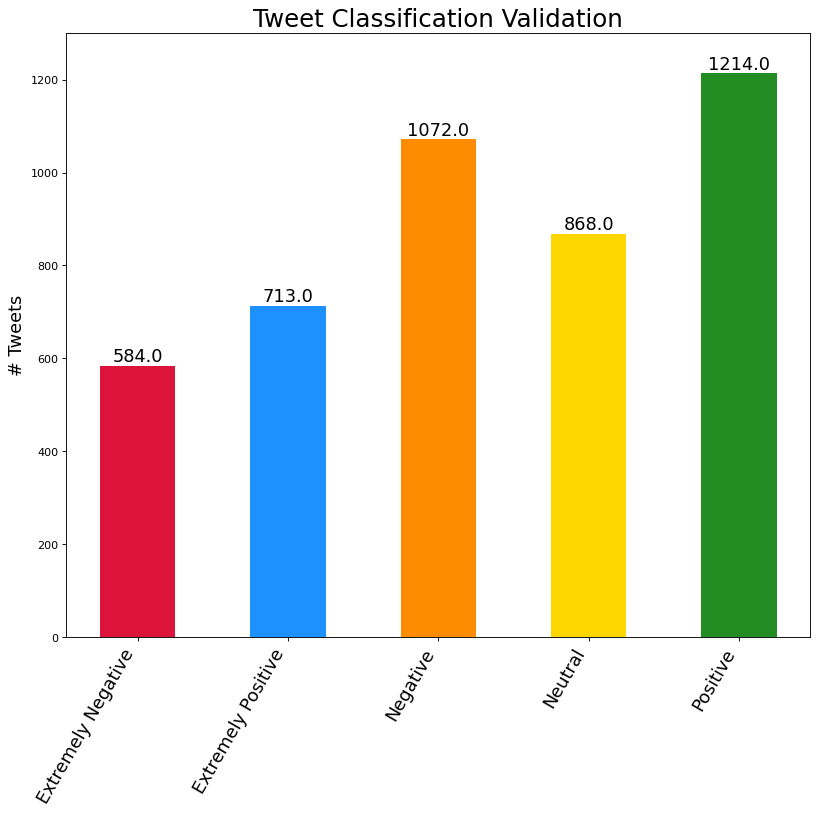

In [ ]:
c = ['crimson', 'dodgerblue', 'darkorange', 'gold', 'forestgreen']

plot_class_dist(num_label_train_index, num_label_train_values, "Tweet Classification Train", 11000, c)
plot_class_dist(num_label_test_index, num_label_test_values, "Tweet Classification Test", 1300, c)
plot_class_dist(num_label_val_index, num_label_val_values, "Tweet Classification Validation", 1300, c)

**Convert five labels to three labels**

In [4]:
def conv_sentiment(tweet_sentiment):
  if tweet_sentiment == "Extremely Positive":
    return "Positive"
  elif tweet_sentiment == "Extremely Negative":
    return "Negative"
  else:
    return tweet_sentiment

In [5]:
Y_train = Y_train.apply(lambda x: conv_sentiment(x))
Y_test = Y_test.apply(lambda x: conv_sentiment(x))
Y_val = Y_val.apply(lambda x: conv_sentiment(x))

num_label_train_index, num_label_train_values = np.unique(Y_train, return_counts=True)
num_label_test_index, num_label_test_values = np.unique(Y_test, return_counts=True)
num_label_val_index, num_label_val_values = np.unique(Y_val, return_counts=True)

**Plot distribution of the classes in train set and test set with three labels**

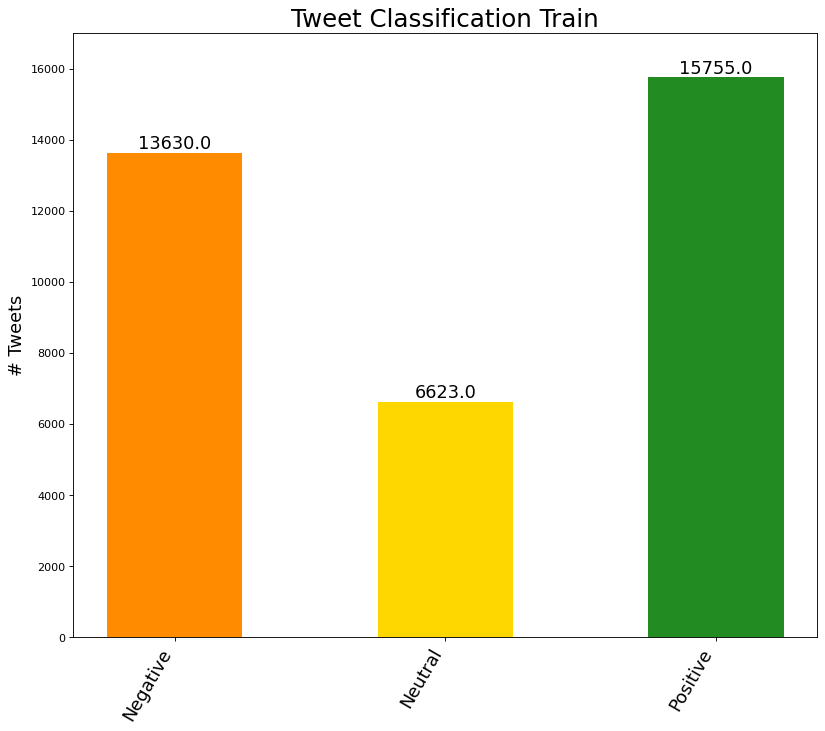

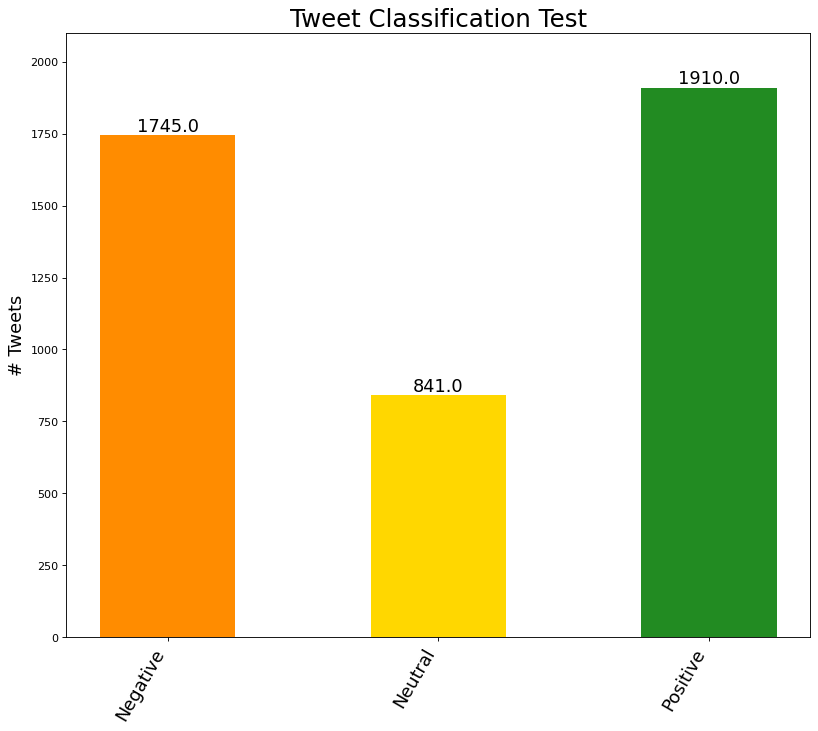

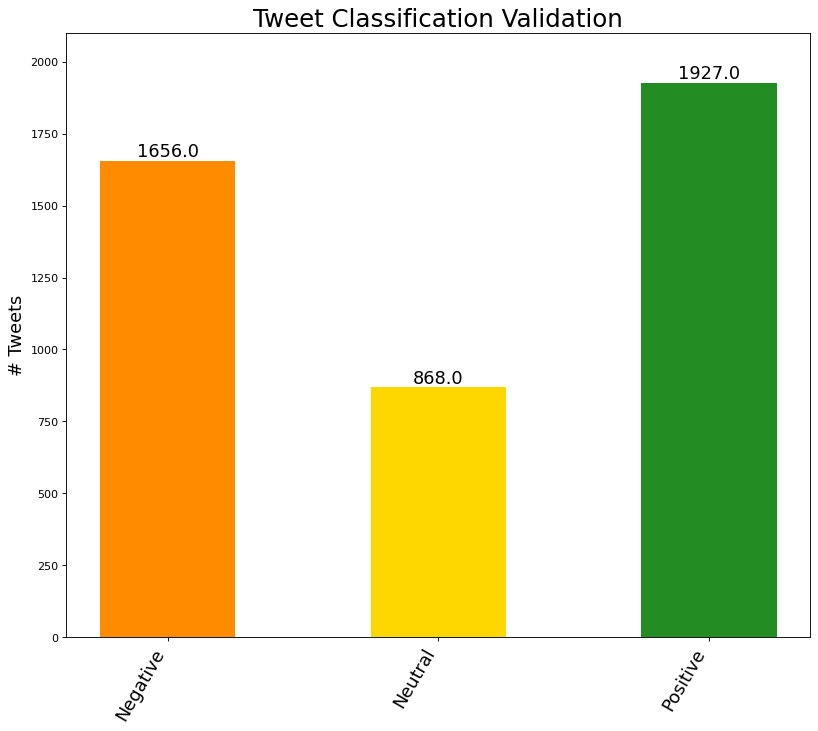

In [ ]:
c = ['darkorange', 'gold', 'forestgreen']

plot_class_dist(num_label_train_index, num_label_train_values, "Tweet Classification Train", 17000, c)
plot_class_dist(num_label_test_index, num_label_test_values, "Tweet Classification Test", 2100, c)
plot_class_dist(num_label_val_index, num_label_val_values, "Tweet Classification Validation", 2100, c)

**Convert string labels to integer labels**

In [6]:
def conv_sentiment_to_int(tweet_sentiment):
  if tweet_sentiment == "Positive":
    return 0
  elif tweet_sentiment == "Negative":
    return 1
  else:
    return 2

In [7]:
Y_train = Y_train.apply(lambda x: conv_sentiment_to_int(x))
Y_test = Y_test.apply(lambda x: conv_sentiment_to_int(x))
Y_val = Y_val.apply(lambda x: conv_sentiment_to_int(x))

**Word2Vec model**

Upload pre-trained model

In [8]:
# Upload Gooogle News model
wv_from_bin = models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/DLA_dataset/GoogleNews-vectors-negative300.bin', binary=True)

# Length of words model
maxlen = 300

vocab = wv_from_bin.vocab
vectors = wv_from_bin.vectors

In [ ]:
# Upload Twitter model
wv_from_bin = gensim.downloader.load('glove-twitter-100')

# Length of words model
maxlen = 100

vocab = wv_from_bin.vocab
vectors = wv_from_bin.vectors

[==================================================] 100.0% 387.1/387.1MB downloaded


****

Train model

In [ ]:
wv_from_bin = models.Word2Vec(sentences=list(X_train.apply(lambda x: x.split(' '))), min_count=1)

# Length of words model
maxlen = 100

vocab = wv_from_bin.wv.vocab
vectors = wv_from_bin.wv.vectors

**Vectorized tweets**

In [ ]:
def sent_vectorizer(sent, model):
  sent_vec = []
  numw = 0
  for w in sent:
    try:
      if numw == 0:
        sent_vec = model[w]
      else:
        sent_vec = np.add(sent_vec, model[w])
      numw+=1
    except:
      pass
  
  return np.asarray(sent_vec)/numw

In [ ]:
x_train = []
for sentence in list(X_train):
    x_train.append(sent_vectorizer(sentence, wv_from_bin))

x_test = []
for sentence in list(X_test):
    x_test.append(sent_vectorizer(sentence, wv_from_bin))

x_val = []
for sentence in list(X_val):
    x_val.append(sent_vectorizer(sentence, wv_from_bin))

In [ ]:
x_train = pad_sequences(np.array(x_train), maxlen=maxlen)
x_test = pad_sequences(np.array(x_test), maxlen=maxlen)
x_val = pad_sequences(np.array(x_val), maxlen=maxlen)

In [ ]:
y_test = Y_test
y_train = Y_train
y_val = Y_val

**Baseline**

Multi-layer Perceptron

In [ ]:
clf= MLPClassifier()
y_pred = clf.fit(x_train, y_train).predict(x_test)

print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 2586
0.4248220640569395


Multi-layer Perceptron with Cross Validation

In [ ]:
parameters = {}
clf = GridSearchCV(MLPClassifier(), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 2586
0.4248220640569395


Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 2586
0.4248220640569395


Gaussian Naive Bayes with Cross Validation

In [ ]:
parameters = {}
clf = GridSearchCV(GaussianNB(), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 2586
0.4248220640569395


Logistic Regression

In [ ]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 2586
0.4248220640569395


Logistic Regression with Cross Validation

In [ ]:
parameters = {}
clf = GridSearchCV(LogisticRegression(random_state=0), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 2586
0.4248220640569395


SVM

In [ ]:
clf = SVC(kernel='linear', max_iter=100, decision_function_shape='ovo')
y_pred = clf.fit(x_train, y_train).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 3655
0.18705516014234874


SVM with Cross Validation

In [ ]:
parameters = {}
clf = GridSearchCV(SVC(kernel='linear', max_iter=100, decision_function_shape='ovo'), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 3655
0.18705516014234874


Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=50, random_state=0, n_estimators=250)
y_pred = clf.fit(x_train, y_train).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 2586
0.4248220640569395


Random Forest with Cross Validation

In [ ]:
parameters = {}
clf = GridSearchCV(RandomForestClassifier(max_depth=50, random_state=0, n_estimators=250), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 4496 points : 2586
0.4248220640569395


**New Network**

In [9]:
y_test = Y_test
y_train = Y_train
y_val = Y_val

# Convert y to categorical 
y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)
y_val  = to_categorical(y_val, 3)

max_features = 30000
tokenizer = Tokenizer(num_words=max_features) # num_words=max_features, 
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_val = tokenizer.texts_to_sequences(X_val)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

# convert tokenized texts into same padding size
#maxlen = 200
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_val_final = pad_sequences(list_tokenized_val, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

47804


In [10]:
embeddings_index = {}
for word, vector in zip(vocab, vectors):
  coefs = np.asarray(vector, dtype='float32')
  embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, maxlen))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

Found 3000000 word vectors.


In [11]:
model=Sequential()

#embedding layer
model.add(Embedding(len(tokenizer.word_index) + 1, maxlen, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(Embedding(max_features, embed_size))

#lstm layer
#model.add(LSTM(128, return_sequences=True, dropout=0.2))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='sigmoid'))

In [12]:
# Learning rate decay
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.5)

#optimizers = [Adam(learning_rate=lr_schedule), SGD(learning_rate=lr_schedule), RMSprop(learning_rate=lr_schedule)]
#batch_sizes = [32, 64, 128]

#Add loss function, metrics, optimizer
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=["acc"])

#Print summary of model
print(model.summary())

history = model.fit(X_train_final, y_train, epochs=10, validation_data=(X_val_final, y_val), batch_size=64)

_,test_acc = model.evaluate(X_test_final, y_test)
print(test_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          14341200  
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 256)          439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 256)          394240    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

**Training graph**

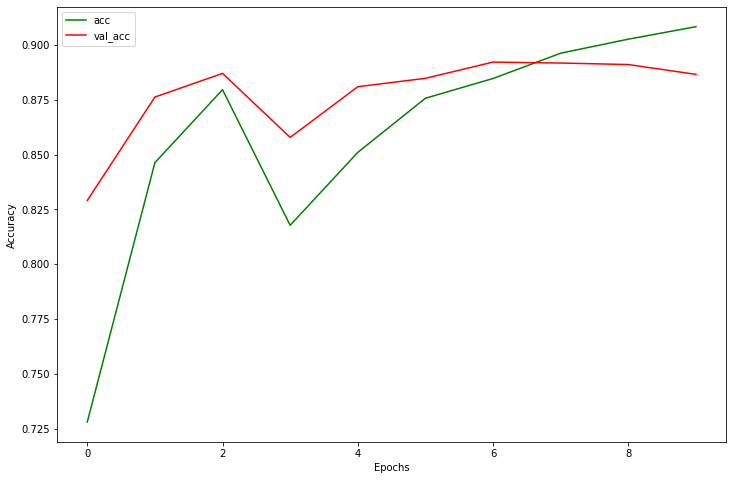

In [13]:
plt.subplots(figsize=(12, 8))
plt.plot(history.history['acc'], 'g')
plt.plot(history.history['val_acc'], 'r')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['acc', 'val_acc'])
plt.show()

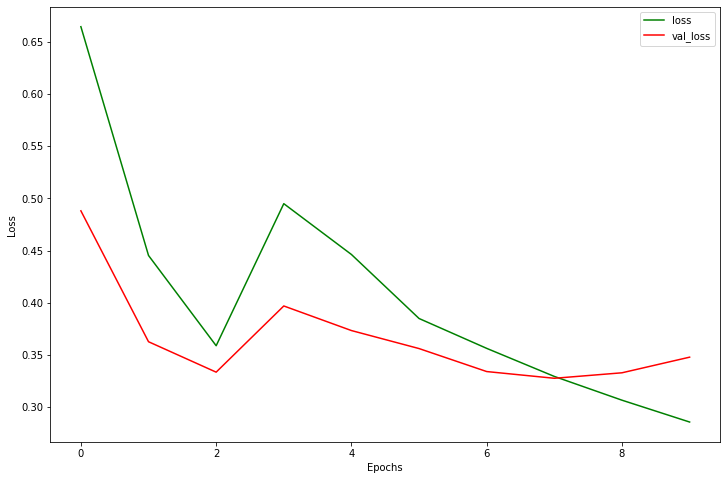

In [14]:
plt.subplots(figsize=(12, 8))
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'r')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

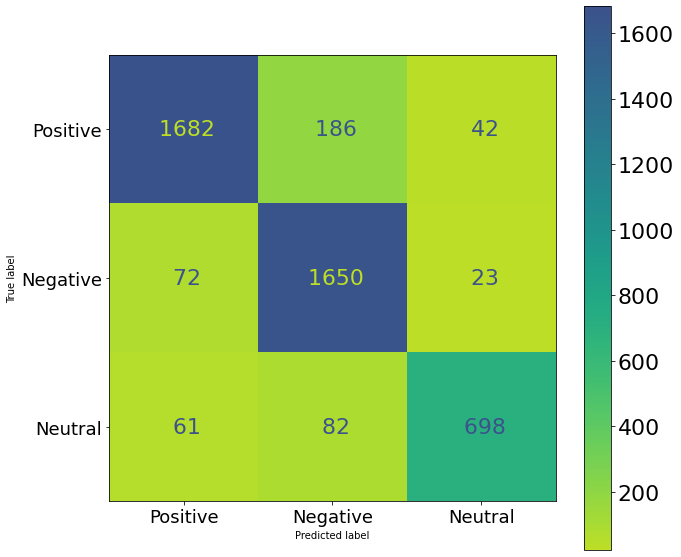

In [17]:
y_pred = model.predict(X_test_final)
y_test  = to_categorical(Y_test, 3)

viridisBig = plt.cm.get_cmap('viridis', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.90, 0.25, 256)))

y_pred = tf.argmax(y_pred, axis=1)
y_test = tf.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
labels = ["Positive", "Negative", "Neutral"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

_, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis="both", which='major', labelsize=18)
plt.rcParams.update({'font.size': 22})
disp.plot(cmap=newcmp, values_format=' ', ax=ax)
plt.show()